# Import Library

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc


# Level 1: Understanding the Terrain

## Load Dataset

In [2]:
# Membaca dataset
df = pd.read_csv("Odyssey 1  Data Set - Telco Data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# result = df.loc[df['tenure'] == 0]
# result

In [4]:
# Memilih fitur numerical dan categorical
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('SeniorCitizen', errors='ignore')
numerical_cols = numerical_cols.append(pd.Index(['TotalCharges']))  # Add 'SeniorCitizen'

categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.drop('customerID', errors='ignore')  # Remove 'customerID'
categorical_cols = categorical_cols.drop('TotalCharges', errors='ignore')  # Remove 'customerID'
categorical_cols = categorical_cols.append(pd.Index(['SeniorCitizen']))  # Add 'SeniorCitizen'

In [5]:
# Mengubah tipe data 
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [6]:
# Menentukan lebar plot untuk visualisasi
n_plots_numerical = len(numerical_cols)
n_rows_numerical = (n_plots_numerical // 3) + (n_plots_numerical % 3 > 0)  # Menentukan jumlah baris berdasarkan jumlah kolom numerik

n_plots_categorical = len(categorical_cols)
n_rows_categorical = (n_plots_categorical // 3) + (n_plots_categorical % 3 > 0)

## Quick EDA

### Structure of Dataset

In [7]:
# Melihat Struktur Dataset:
print("Shape of dataset:", df.shape)

Shape of dataset: (7043, 21)


- Terdapat 21 fitur dalam dataset.
- Terdapat 7043 data dalam datset yang tersedia.

In [8]:
# Melihat kolom-kolom dari data
print("\nColumns and data types:\n", df.dtypes)


Columns and data types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


- Terdapat beberapa fitur yang tipe datanya tidak sesuai.
- SeniorCitizen harusnya fitur categorical.
- TotalCharges harusnya fitur numerical.

### Checking Missing Value

> Terdapat missing value pada feature TotalCharges sebanyak 11 data.

In [9]:
# Mengecek missing values
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [10]:
df[df.isna().any(axis=1)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


### Checking Data Duplicate

> Tidak ada data yang duplikat dalam dataset.

In [11]:
# Mengecek jumlah data duplikat
duplicates = df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicates}")

Jumlah data duplikat: 0


### Checking Data Outlier

> Tidak ada data outlier dalam dataset.

In [12]:
# Mengecek data outlier dengan metode IQR
for col in numerical_cols:
	Q1 = df[col].quantile(0.25)
	Q3 = df[col].quantile(0.75)
	IQR = Q3 - Q1
	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR
	outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
	print(f"Jumlah Outliers Column {col}: {len(outliers)}")

Jumlah Outliers Column tenure: 0
Jumlah Outliers Column MonthlyCharges: 0
Jumlah Outliers Column TotalCharges: 0


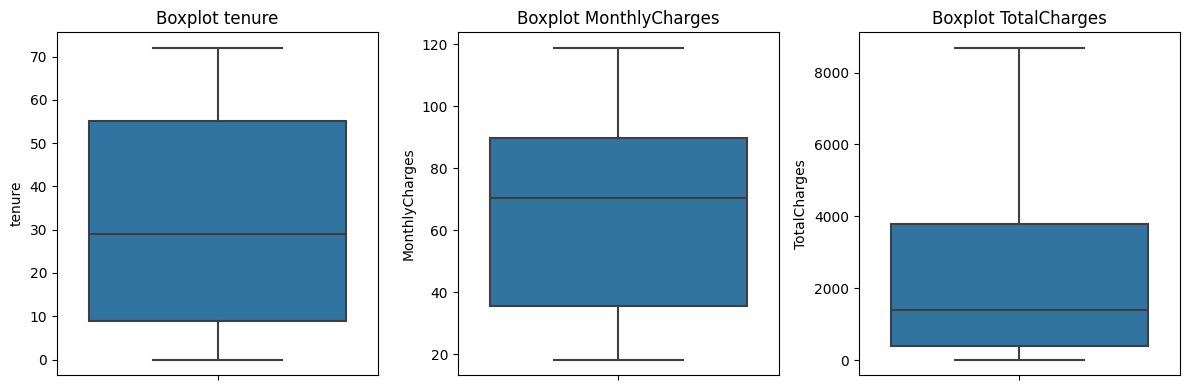

In [13]:
# Visualisasi boxplot untuk melihat data outlier
num_features = len(numerical_cols)
cols = 3
rows = math.ceil(num_features / cols)
plt.figure(figsize=(cols * 4, rows * 4))
for i, column in enumerate(numerical_cols, 1):
	plt.subplot(rows, cols, i)
	sns.boxplot(y=column, data=df)
	plt.title(f'Boxplot {column}')
plt.tight_layout()
plt.show()

Berdasarkan grafik tersebut, dapat diambil beberapa insight yaitu sebagai berikut ini.
- Tenure: Pelanggan baru (tenure rendah) merupakan bagian signifikan dari dataset, sehingga program retensi untuk pelanggan baru bisa menjadi prioritas. Pelanggan dengan tenure lebih lama cenderung lebih loyal, sehingga mereka bisa difokuskan untuk upselling atau program loyalitas.

- MonthlyCharges: Pelanggan dengan MonthlyCharges lebih tinggi (di atas Q3) mungkin memiliki kebutuhan layanan lebih kompleks, sehingga strategi peningkatan nilai (value proposition) pada segmen ini sangat penting. Sedangkan pelanggan dengan biaya bulanan lebih rendah (di bawah Q1) mungkin lebih rentan terhadap churn karena mereka memiliki keterikatan layanan yang lebih rendah.

- TotalCharges: Pelanggan dengan TotalCharges rendah (di bawah Q1) kemungkinan besar adalah pelanggan baru atau pelanggan churn lebih cepat. Sedangkan pelanggan dengan TotalCharges tinggi (di atas Q3) merupakan pelanggan loyal yang dapat menjadi target untuk program upselling.


## Statistical Summaries

In [14]:
# Statistik deskriptif untuk fitur numerical
df[numerical_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


Berdasarkan statistik deskriptif tersebut, dapat diambil beberapa insight yakni sebagai berikut.
- Tenure (Durasi Pelanggan Menjadi Langganan): Ada perbedaan signifikan antara pelanggan baru dan pelanggan yang sudah lama, yang dapat memengaruhi tingkat churn. Pelanggan baru mungkin lebih rentan terhadap churn.

- MonthlyCharges (Biaya Bulanan): Pelanggan dengan biaya lebih tinggi mungkin memiliki kebutuhan layanan yang lebih kompleks, tetapi mereka juga mungkin lebih sensitif terhadap harga, yang bisa meningkatkan risiko churn.

- TotalCharges (Total Biaya yang Dibayarkan): Pelanggan dengan TotalCharges rendah mungkin pelanggan baru atau pelanggan churn lebih cepat, sedangkan pelanggan dengan TotalCharges tinggi menunjukkan loyalitas.

In [15]:
# Statistik deskriptif untuk fitur categorical
df[categorical_cols].describe(include='O')

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


Berdasarkan statistik deskriptif tersebut, dapat diambil beberapa insight yakni sebagai berikut.
- Gender: Gender sepertinya tidak menjadi faktor utama dalam churn, tetapi analisis lebih lanjut diperlukan untuk konfirmasi.

- Partner & Dependents: Pelanggan tanpa pasangan dan tanggungan mungkin lebih fleksibel untuk membatalkan layanan, sehingga lebih rentan terhadap churn.

- PhoneService dan MultipleLines: Pelanggan dengan layanan multiple lines mungkin memiliki kebutuhan lebih kompleks, yang dapat memengaruhi loyalitas mereka.

- InternetService: Pelanggan dengan Fiber optic mungkin memiliki ekspektasi lebih tinggi terhadap layanan, sehingga bisa lebih sensitif terhadap masalah kualitas.

- Add-on Services (OnlineSecurity, OnlineBackup, dll): Kurangnya adopsi layanan tambahan dapat menunjukkan peluang upselling. Namun, pelanggan tanpa add-on mungkin lebih mudah churn karena kurangnya keterikatan.

- Contract: Kontrak jangka pendek adalah salah satu indikator utama churn, dan pelanggan dengan kontrak ini perlu lebih diperhatikan.

- PaperlessBilling: Paperless Billing dapat menjadi indikasi bahwa pelanggan lebih modern, tetapi mungkin juga lebih sensitif terhadap masalah pembayaran otomatis.

- PaymentMethod: Pelanggan dengan metode pembayaran manual seperti electronic check mungkin lebih rentan terhadap churn dibandingkan metode pembayaran otomatis seperti kartu kredit atau debit otomatis.

- Churn: Meskipun mayoritas pelanggan tetap setia, ada proporsi churn yang signifikan (~26,5%). Ini menunjukkan ada ruang untuk meningkatkan retensi pelanggan.

## Label (Churn) Distribution


Churn distribution:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64


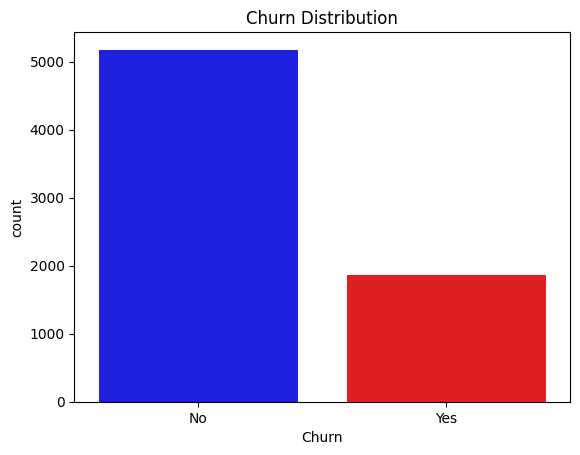

In [16]:
# Distribusi churn
print("\nChurn distribution:\n", df['Churn'].value_counts())
sns.countplot(data=df, x='Churn', palette=['blue', 'red'])
plt.title("Churn Distribution")
plt.show()

- Terdapat class imbalance pada label (churn) yang cukup besar.

## Univariate Analysis

### Numeric Variables

c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


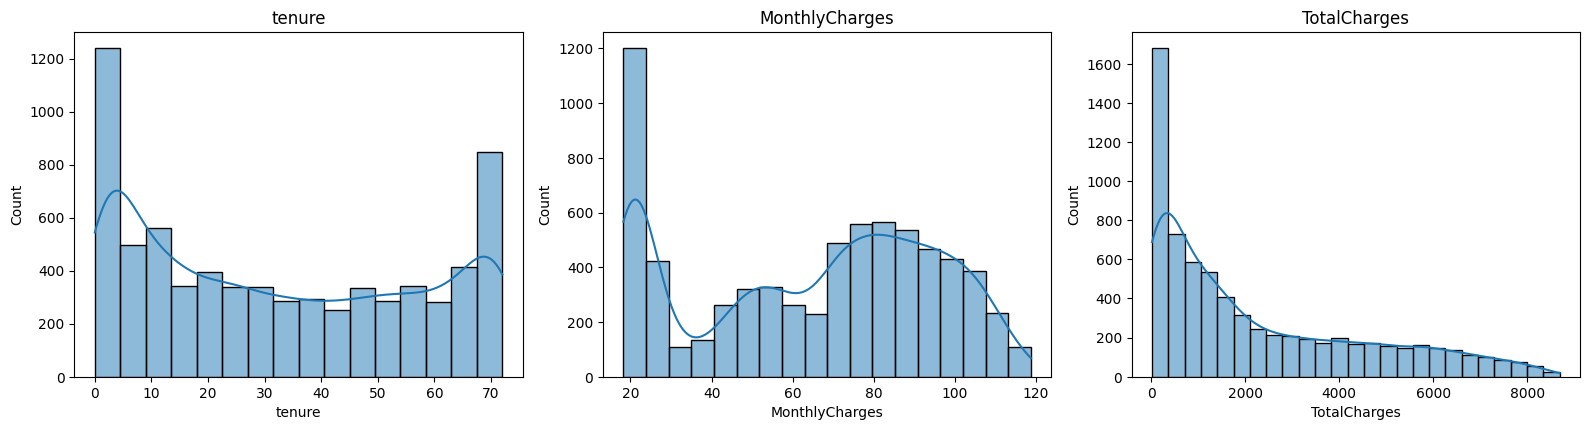

In [17]:
# Visualisasi persebaran data untuk feature numerical
plt.figure(figsize=(16, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

Berikut adalah insight dari hasil visualisasi tersebut.
- Tenure (Lama Berlangganan): Sebagian besar pelanggan berada pada awal masa langganan (tenure rendah, terutama 0-10 bulan). 

- MonthlyCharges (Biaya Bulanan): Biaya bulanan bervariasi dengan puncak di nilai rendah hingga menengah (~20-50) dan penyebaran yang cukup merata hingga sekitar 120.

- TotalCharges (Total Biaya yang Dibayar): Sebagian besar pelanggan memiliki total biaya rendah (banyak di bawah 2000), yang kemungkinan besar terkait dengan pelanggan baru (tenure rendah).

### Categorical Variables

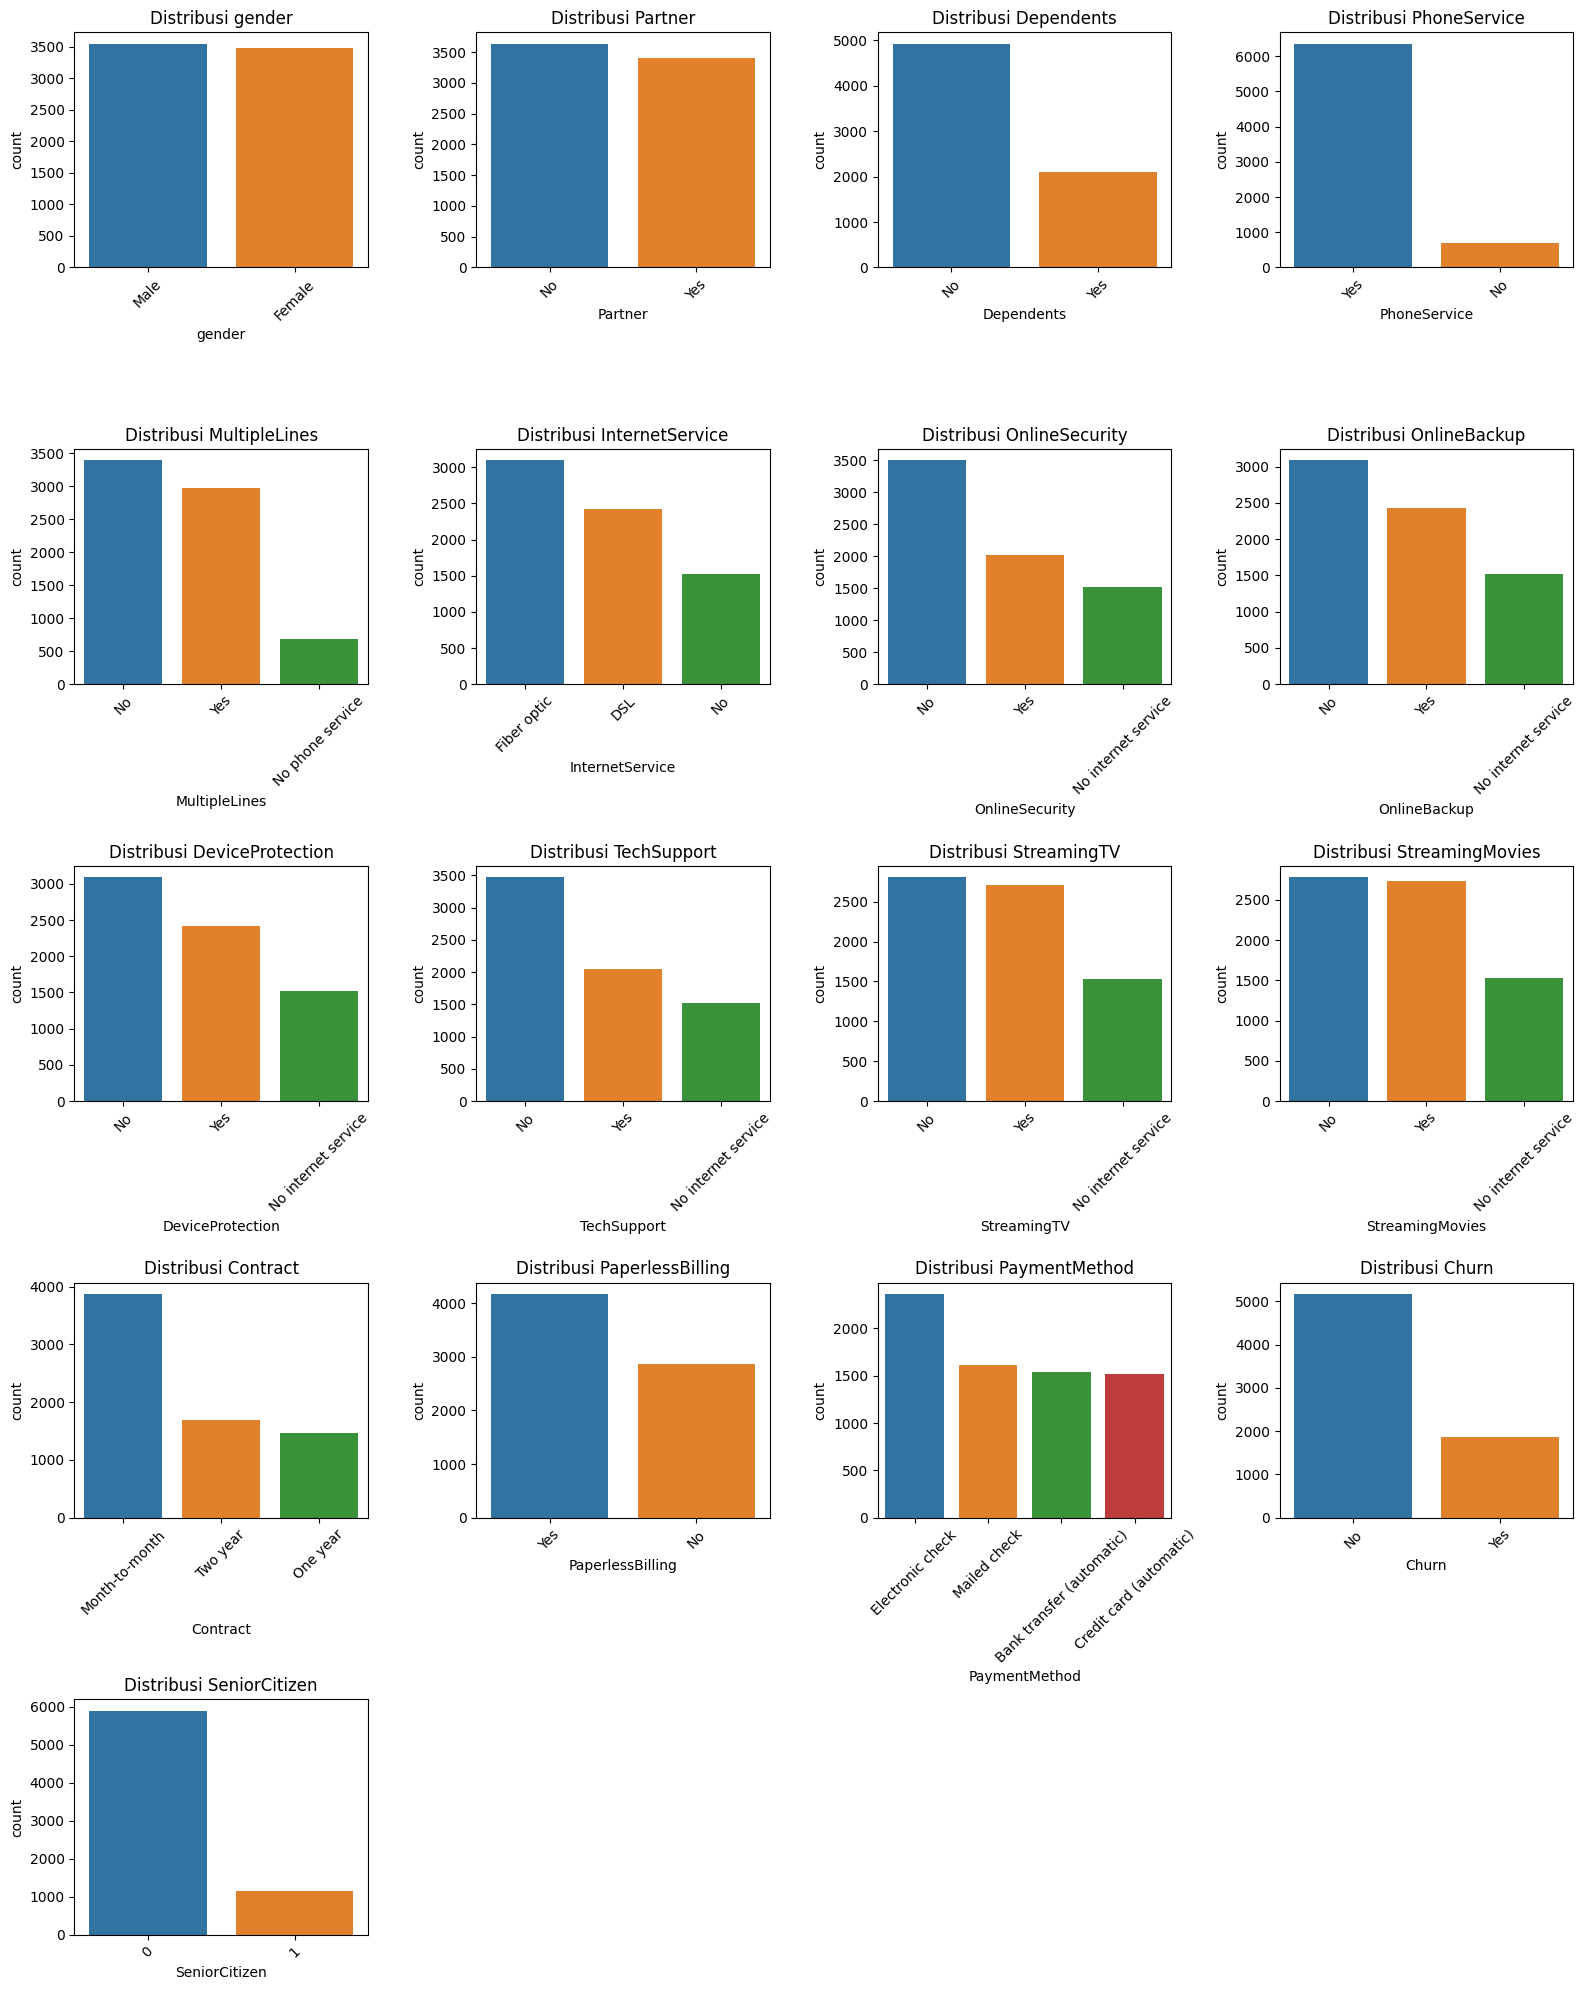

In [18]:
# Univariate Analysis for Categorical Variables
num_features = len(categorical_cols)
cols = 4
rows = math.ceil(num_features / cols)
plt.figure(figsize=(cols * 4, rows * 4))
for i, column in enumerate(categorical_cols, 1):
	plt.subplot(rows, cols, i)
	sns.countplot(x=df[column], order=df[column].value_counts().index)
	plt.title(f'Distribusi {column}')
	plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Berdasarkan grafik tersebut, berikut merupakan insight-insight yang dapat diambil.
- Gender: Distribusi gender seimbang antara pria dan wanita. Tidak ada bias gender dalam dataset, sehingga gender mungkin tidak menjadi faktor utama yang memengaruhi analisis churn.

- Partner & Dependents: Pelanggan tanpa pasangan atau tanggungan kemungkinan besar adalah individu lajang, yang bisa lebih rentan churn karena kebutuhan layanan mereka lebih fleksibel.

- PhoneService & MultipleLines: Hampir semua pelanggan menggunakan layanan telepon. Selain itu, sebagian besar pelanggan menggunakan layanan telepon tunggal (MultipleLines: No), sementara sebagian kecil menggunakan MultipleLines. Perusahaan dapat menyediakan bundling layanan tambahan untuk pelanggan MultipleLines dapat meningkatkan nilai penjualan.

- InternetService: Fiber optic mendominasi, tetapi pelanggan ini mungkin lebih rentan churn karena biaya layanan yang lebih tinggi dibandingkan DSL.

- OnlineSecurity, OnlineBackup, DeviceProtection, dan TechSupport: Layanan tambahan seperti OnlineSecurity, OnlineBackup, DeviceProtection, dan TechSupport lebih banyak tidak digunakan oleh pelanggan. Pelanggan mungkin kurang teredukasi tentang manfaat layanan ini, sehingga program edukasi atau promosi dapat meningkatkan adopsi layanan tambahan.

- StreamingTV & StreamingMovies: Sebagian besar pelanggan menggunakan layanan StreamingTV dan StreamingMovies, tetapi proporsi yang tidak menggunakan layanan ini juga cukup besar. Pelanggan yang menggunakan layanan streaming bisa menjadi fokus untuk peningkatan layanan atau penawaran eksklusif.

- Contract: Mayoritas pelanggan berada pada kontrak Month-to-month, sementara kontrak Two year memiliki proporsi paling kecil. Pelanggan Month-to-month lebih rentan churn dibandingkan kontrak jangka panjang, sehingga strategi untuk mengonversi pelanggan ini ke kontrak jangka panjang dapat membantu mengurangi churn.

- PaperlessBilling & PaymentMethod: Sebagian besar pelanggan menggunakan metode penagihan tanpa kertas (PaperlessBilling: Yes). Selain itu, pembayaran elektronik (Electronic check) adalah metode pembayaran paling dominan. Pelanggan PaperlessBilling dengan Electronic check mungkin mencari kenyamanan, tetapi bisa lebih mudah churn karena metode ini kurang melibatkan pelanggan dibandingkan metode otomatis seperti kartu kredit.

- SeniorCitizen: Sebagian besar pelanggan bukan SeniorCitizen (pelanggan lansia). Lansia mungkin memiliki kebutuhan layanan berbeda, sehingga pendekatan yang dipersonalisasi untuk kelompok ini bisa efektif.

- Churn: Sebagian besar pelanggan tetap bertahan (Churn: No), tetapi ada jumlah signifikan yang churn. Fokus pada faktor-faktor yang menyebabkan churn bisa menjadi prioritas untuk mempertahankan pelanggan.






## Multivariate Analysis

### Correlation Matrix

In [19]:
df[numerical_cols].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.00000,0.247900,0.825880
MonthlyCharges,0.24790,1.000000,0.651065
TotalCharges,0.82588,0.651065,1.000000


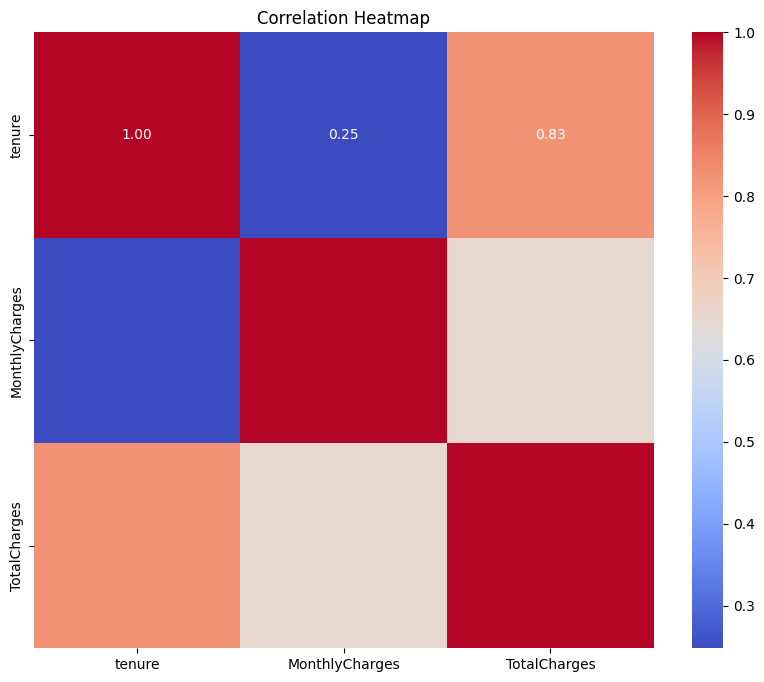

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

# Level 2: Finding the Drivers of Churn

In [21]:
target_col = 'Churn'
categorical_cols = categorical_cols.drop(target_col, errors='ignore')  # Remove target
df[target_col] = df[target_col].apply(lambda x: 1 if x == 'Yes' else 0)  # Encode churn ke 1/0

## Feature Importance for Numerical Columns

> Feature numerical tenure (durasi berlangganan) memiliki pengaruh paling signifikan terhadap churn dengan korelasi negatif.

In [22]:
# Korelasi antara churn dengan kolom numerik
print("Korelasi antara churn dengan kolom numerik lainnya:")
correlation = df[numerical_cols].corrwith(df[target_col])
print(correlation)

Korelasi antara churn dengan kolom numerik lainnya:
tenure           -0.352229
MonthlyCharges    0.193356
TotalCharges     -0.199484
dtype: float64


Berdasarkan hasil feature importance tersebut, berikut insight-insight yang didapatkan.

- Tenure (Durasi Berlangganan) memiliki pengaruh paling signifikan terhadap churn dengan korelasi negatif. Artinya, semakin lama pelanggan berlangganan, semakin kecil kemungkinan mereka untuk churn. Pelanggan baru atau dengan durasi langganan pendek memiliki risiko churn yang lebih tinggi.

- MonthlyCharges (Biaya Bulanan) menunjukkan korelasi positif dengan churn, meskipun pengaruhnya lebih kecil. Pelanggan dengan biaya bulanan lebih tinggi memiliki sedikit risiko churn yang lebih besar, kemungkinan karena persepsi bahwa biaya terlalu mahal dibandingkan dengan manfaat.

- TotalCharges (Total Pembayaran Keseluruhan) menunjukkan korelasi negatif, meskipun tidak sekuat tenure. Ini menunjukkan bahwa pelanggan dengan akumulasi pembayaran yang tinggi (biasanya pelanggan dengan durasi langganan panjang) cenderung lebih loyal dan lebih kecil kemungkinan untuk churn.

## Analysis of Categorical Columns

> Faktor utama yang memengaruhi churn adalah jenis layanan tambahan (OnlineSecurity, TechSupport, dsb.), jenis kontrak, dan metode pembayaran.


Analisis kolom kategorikal:


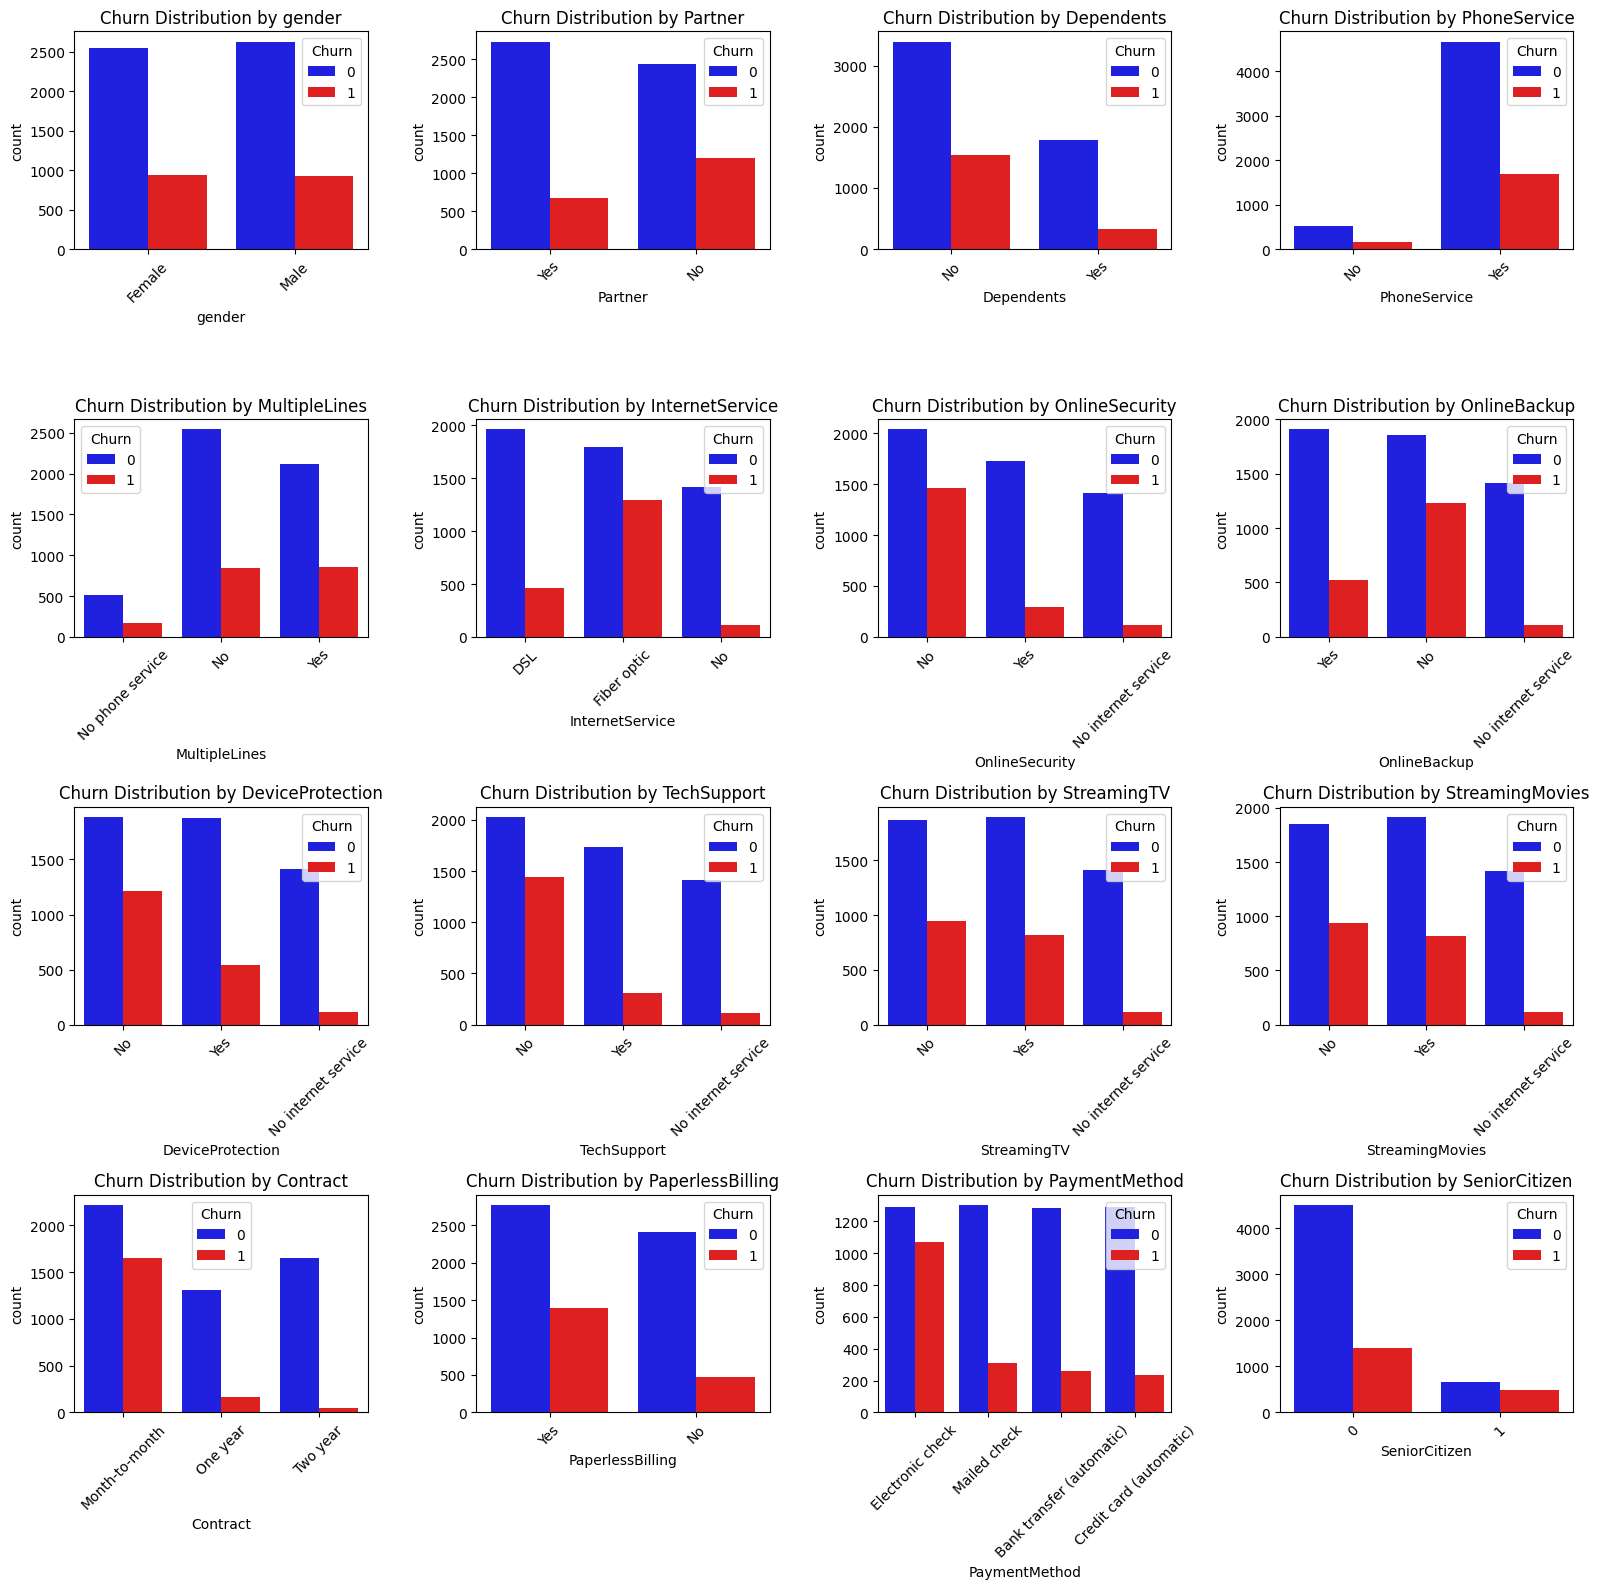

In [23]:
# Distribusi feature categorical untuk setiap churn
print("\nAnalisis kolom kategorikal:")
num_features = len(categorical_cols)
cols = 4
rows = math.ceil(num_features / cols)
plt.figure(figsize=(cols * 4, rows * 4))
for i, column in enumerate(categorical_cols, 1):
	plt.subplot(rows, cols, i)
	sns.countplot(data=df, x=column, hue='Churn', palette=['blue', 'red'])
	plt.title(f"Churn Distribution by {column}")
	plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Berdasarkan hasil visualisasi tersebut, dapat diambil beberapa insight yaitu sebagai berikut.
- Gender: Berdasarkan distribusinya, tidak ada perbedaan yang signifikan antara gender dalam hal churn. Hal ini menunjukkan bahwa feature gender bukan faktor utama yang mempengaruhi churn.

- Partner: Pelanggan tanpa pasangan memiliki proporsi churn yang lebih tinggi dibandingkan pelanggan dengan pasangan. Pelanggan yang memiliki pasangan cenderung lebih setia.

- Dependents: Pelanggan tanpa tanggungan memiliki proporsi churn yang lebih tinggi dibandingkan pelanggan dengan tanggungan. Pelanggan dengan tanggungan mungkin memiliki preferensi untuk stabilitas layanan.

- PhoneService: Tidak ada perbedaan signifikan dalam distribusi churn berdasarkan PhoneService. Feature PhoneService bukan faktor penentu churn yang kuat.

- MultipleLines: Pelanggan tanpa MultipleLines memiliki proporsi churn lebih tinggi. Menawarkan layanan tambahan seperti MultipleLines dapat meningkatkan retensi pelanggan.

- InternetService: Pelanggan dengan "DSL" atau tanpa layanan internet memiliki churn lebih rendah dibandingkan pelanggan dengan "Fiber optic". Pelanggan Fiber optic cenderung lebih sering churn, kemungkinan karena ekspektasi yang lebih tinggi terhadap kualitas layanan.

- OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport: Pelanggan yang tidak menggunakan layanan ini memiliki proporsi churn yang jauh lebih tinggi. Layanan tambahan seperti OnlineSecurity, OnlineBackup, DeviceProtection, dan TechSupport sangat penting untuk retensi.

- StreamingTV & StreamingMovies: Pelanggan yang tidak menggunakan layanan streaming memiliki proporsi churn lebih tinggi. Penawaran layanan streaming yang menarik dapat meningkatkan loyalitas pelanggan.

- Contract: Pelanggan dengan kontrak bulanan memiliki churn tertinggi dibandingkan pelanggan dengan kontrak satu atau dua tahun. Kontrak jangka panjang terbukti mengurangi churn.

- PaperlessBilling: Pelanggan dengan PaperlessBilling memiliki churn lebih tinggi. PaperlessBilling mungkin berkorelasi dengan pengalaman pelanggan yang kurang memuaskan.

- PaymentMethod: Pelanggan yang menggunakan metode "Electronic check" memiliki churn tertinggi dibandingkan metode lainnya. "Electronic check" mungkin dianggap kurang nyaman atau mahal. Mendorong pelanggan beralih ke metode pembayaran otomatis atau kartu kredit/debit dapat membantu mengurangi churn.

- SeniorCitizen: Pelanggan yang merupakan SeniorCitizen memiliki proporsi churn lebih tinggi. Perusahaan dapat menawarkan program khusus untuk pelanggan lansia untuk meningkatkan retensi.


## Chi-Square Test

> Feature Contract adalah faktor yang paling signifikan terhadap churn.

In [24]:
# Chi-Square Test untuk kolom kategorikal
print("\nChi-Square Test Results:")
feature_correlation_churn = []
for col in categorical_cols:
	if col != target_col:
		contingency_table = pd.crosstab(df[col], df[target_col])
		chi2, p, dof, expected = chi2_contingency(contingency_table)
		print(f"- {col}: Chi2 = {chi2:.2f}, p-value = {p:.5f}", end=' => ')
		if p < 0.05:
			feature_correlation_churn.append(col)
			print(f"{col} memiliki hubungan signifikan dengan churn.")
		else:
			print(f"{col} tidak memiliki hubungan signifikan dengan churn.")


Chi-Square Test Results:
- gender: Chi2 = 0.48, p-value = 0.48658 => gender tidak memiliki hubungan signifikan dengan churn.
- Partner: Chi2 = 158.73, p-value = 0.00000 => Partner memiliki hubungan signifikan dengan churn.
- Dependents: Chi2 = 189.13, p-value = 0.00000 => Dependents memiliki hubungan signifikan dengan churn.
- PhoneService: Chi2 = 0.92, p-value = 0.33878 => PhoneService tidak memiliki hubungan signifikan dengan churn.
- MultipleLines: Chi2 = 11.33, p-value = 0.00346 => MultipleLines memiliki hubungan signifikan dengan churn.
- InternetService: Chi2 = 732.31, p-value = 0.00000 => InternetService memiliki hubungan signifikan dengan churn.
- OnlineSecurity: Chi2 = 850.00, p-value = 0.00000 => OnlineSecurity memiliki hubungan signifikan dengan churn.
- OnlineBackup: Chi2 = 601.81, p-value = 0.00000 => OnlineBackup memiliki hubungan signifikan dengan churn.
- DeviceProtection: Chi2 = 558.42, p-value = 0.00000 => DeviceProtection memiliki hubungan signifikan dengan churn.
-

In [25]:
# Hasil Chi-square test
print(f'Feature yang memiliki hubungan signifikan dengan churn :', end=' ')
for i, col in enumerate(feature_correlation_churn, start=1):
	if i == len(feature_correlation_churn):
		print(f'{col}.')
	else:

	 	print(f'{col}', end=', ')

Feature yang memiliki hubungan signifikan dengan churn : Partner, Dependents, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, SeniorCitizen.


Berdasarkan hasil Chi-square test tersebut, dapat diambil beberapa insight yakni sebagai berikut.

- Contract adalah faktor yang paling signifikan, menunjukkan bahwa pelanggan dengan kontrak bulanan memiliki risiko churn yang jauh lebih tinggi dibandingkan pelanggan dengan kontrak tahunan atau dua tahunan.

- Feature PaymentMethod juga penting, dengan metode pembayaran otomatis seperti auto-pay menunjukkan loyalitas yang lebih tinggi.

- Banyak feature categorical yang memiliki hubungan signifikan dengan churn, terutama kolom yang berhubungan dengan jenis layanan yang digunakan (seperti InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies) dan pengaturan kontrak (seperti Contract dan PaymentMethod).

- Feature seperti Partner dan Dependents menunjukkan bahwa pelanggan dengan pasangan atau tanggungan cenderung lebih loyal dibandingkan yang tidak memiliki.

- Feature Gender dan PhoneService tidak memiliki hubungan signifikan dengan churn. Artinya, jenis kelamin pelanggan dan keberadaan layanan telepon tidak berdampak besar terhadap risiko churn.


# Level 3: Building a Predictive Model

In [26]:
df_clean = df.copy()
df_clean.shape

(7043, 21)

## Data Preparation

### Handling Missing Value

In [27]:
# Impute dengan median
imputer_num = SimpleImputer(strategy="median")
df_clean['TotalCharges'] = imputer_num.fit_transform(df_clean[['TotalCharges']])

Q: Kenapa harus impute? Kenapa impute dengan median?

A: Hal ini agar mencegah hilangnya informasi penting. Impute menggunakan median karena distribusi data pada feature yang missing value adalah skewed, bukan distribusi normal.

### Feature Selection

In [28]:
# Buang fitur customerID, gender,PhoneService
df_clean.drop(['customerID', 'gender', 'PhoneService'], axis=1, inplace=True)

- Proses feature selection dilakukan untuk memilih fitur-fitur yang akan digunakan dalam Machine Learning.
- Pada proses ini, dilakukan pembuangan atau penghapusan fitur yang dirasa kurang berpengaruh terhadap churn dari hasil analisis pada tahap sebelumnya. Dimana fitur-fitur tersebut yakni 'customerID', 'gender', dan 'PhoneService'.

### Feature Encoding

In [29]:
# Feature encoding dengan one-hot encoding
one_hot_columns = ['Contract', 'MultipleLines', 'InternetService', 'PaymentMethod']
encoder = OneHotEncoder(sparse_output=False, drop='if_binary')  # untuk menghindari multicollinearity
data_encoded = encoder.fit_transform(df_clean[one_hot_columns])

# Mengubah encoded data menjadi DataFrame with nama kolom yang sesuai
column_encoded = encoder.get_feature_names_out(one_hot_columns)
df_encoded = pd.DataFrame(data_encoded, columns=column_encoded, index=df_clean.index)

# Menghapus kolom yang asli dan menggabungkannya dengan encoded column yg baru
df_clean = df_clean.drop(one_hot_columns, axis=1)
df_clean = pd.concat([df_clean, df_encoded], axis=1)

In [30]:
# Feature encoding dengan label encoding untuk variabel categorical yang tersisa karena variabel tersebut adalah biner
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

df_clean = df_clean.apply(lambda x: object_to_int(x))
df_clean.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,...,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,2,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0,34,2,0,2,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,0,2,2,2,0,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,0,45,2,0,2,2,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,2,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


- Proses feature encoding dilakukan untuk mengubah fitur-fitur categorical menjadi angka. Proses feature encoding dilakukan dengan menggunakan dua metode, yakni one-hot encoding dan label encoding.
- Feature encoding dengan one-hot encoding dilakukan pada fitur-fitur yang tidak memiliki urutan, seperti 'Contract', 'MultipleLines', 'InternetService', dan 'PaymentMethod'.
- Untuk feature sisanya (yang memiliki urutan) akan dilakukan proses feature encoding dengan menggunakan label encoding.

### Handling Class Imbalace

In [31]:
# Handling Class Imbalance
x = df_clean.drop("Churn", axis=1)
y = df_clean["Churn"]
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x, y)


Churn distribution after SMOTE:
 Churn
0    5174
1    5174
Name: count, dtype: int64


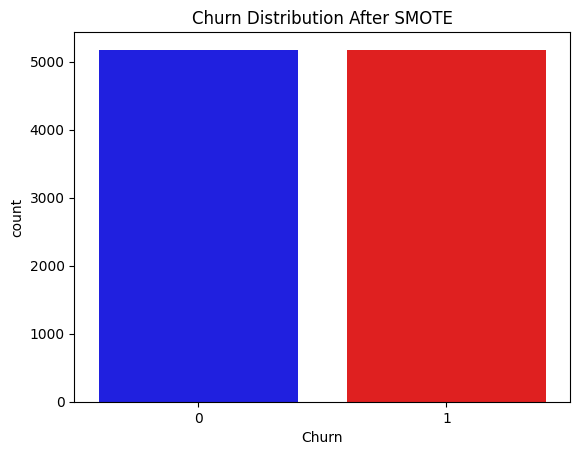

In [32]:
# Distribusi target after SMOTE
print("\nChurn distribution after SMOTE:\n", y_smote.value_counts())
sns.countplot(data=x_smote, x=y_smote, palette=['blue', 'red'])
plt.title("Churn Distribution After SMOTE")
plt.show()

Q: Kenapa menggunakan SMOTE?

A: Hal ini dikarenakan SMOTE membuat representasi yang lebih seimbang dengan menghasilkan data sintetis untuk kelas minoritas tanpa menghapus data kelas mayoritas.

### Normalization

In [33]:
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(x_smote)

Q: Kenapa normalisasi? Kenapa bukan standarisasi?

A: Alasannya yakni sebagai berikut.
- Karena distribusi dari sebagian besar feature bukan distribusi normal / hampir normal.
- Model yang akan digunakan adalah model yang berbasis jarak / magnitude, seperti KNN, Nueral Network, dsb.


### Data Split

In [34]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y_smote, test_size=0.2, random_state=42)

- Pada proses data split, data dibagi menjadi data train dan data test, dengan perbandingan 80% dan 20%.

## Modeling

In [35]:
# Inisialisasi model
models = {
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": GradientBoostingClassifier(random_state=42)
}

In [36]:
# Train model
model_results = {}
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_results[name] = y_pred

Q: Algoritma apa yang akan dipakai? Dan apa alasannya?

A: Alasannya yakni sebagai berikut.
- Algoritma Support Vector Machine (SVM) cocok untuk data non-linear dan menghasilkan margin keputusan yang kuat.
- Algoritma yang akan dipilih yaitu SVM, Support Vector Machine (SVM), Logistic Regression, Random Forest, dan XGBoost (Gradient Boosting).
- Algoritma Logistic Regression merupakan algoritma yang sederhana, mudah diinterpretasikan, dan cocok untuk kasus klasifikasi biner.
- Algoritma model berbasis ensemble seperti algoritma Random Forest, dapat menangani data non-linear dengan baik dan memberikan informasi pentingnya fitur.
- Algoritma XGBoost (Gradient Boosting) cukup efektif untuk klasifikasi dengan performa tinggi karena menggabungkan model yang lebih lemah.


## Evaluation

### Classification Report

In [37]:
for name, y_pred in model_results.items():
    print(f"Classification report {name}:")
    print(classification_report(y_test, y_pred))
    # print(f"ROC-AUC: {roc_auc_score(y_test, models[name].predict_proba(x_test)[:, 1]):.2f}\n")
    print()

Classification report SVM:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1021
           1       0.84      0.84      0.84      1049

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070


Classification report Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1021
           1       0.80      0.84      0.82      1049

    accuracy                           0.81      2070
   macro avg       0.81      0.81      0.81      2070
weighted avg       0.81      0.81      0.81      2070


Classification report Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1021
           1       0.88      0.84      0.86      1049

    accuracy                           0.86      2070
   macro avg       

Berdasarkan hasil classification report tersebut, berikut beberapa hasil analisis yang dapat diambil.

- Support Vector Machine (SVM)
	- Precision dan recall yang seimbang, tetapi sedikit lebih rendah dibandingkan XGBoost dan Random Forest.
	- F1-score untuk kedua kelas konsisten tetapi tidak seunggul dua model sebelumnya.

- Logistic Regression
	- Precision untuk kelas negatif lebih tinggi, tetapi recall untuk kelas positif lebih rendah.
	- F1-score menunjukkan performa yang memadai, tetapi tidak sebaik tiga model lainnya.

- Random Forest
	- Sangat seimbang dalam precision dan recall untuk kedua kelas.
	- F1-score untuk kedua kelas hampir sama dengan XGBoost, menunjukkan bahwa ini adalah alternatif yang kuat.

- XGBoost
	- Precision dan recall yang hampir seimbang untuk kedua kelas.
	- F1-score menunjukkan bahwa model ini unggul dalam memprediksi kedua kelas secara akurat, dengan nilai keseluruhan lebih tinggi dibandingkan Logistic Regression.


### AOC-RUC

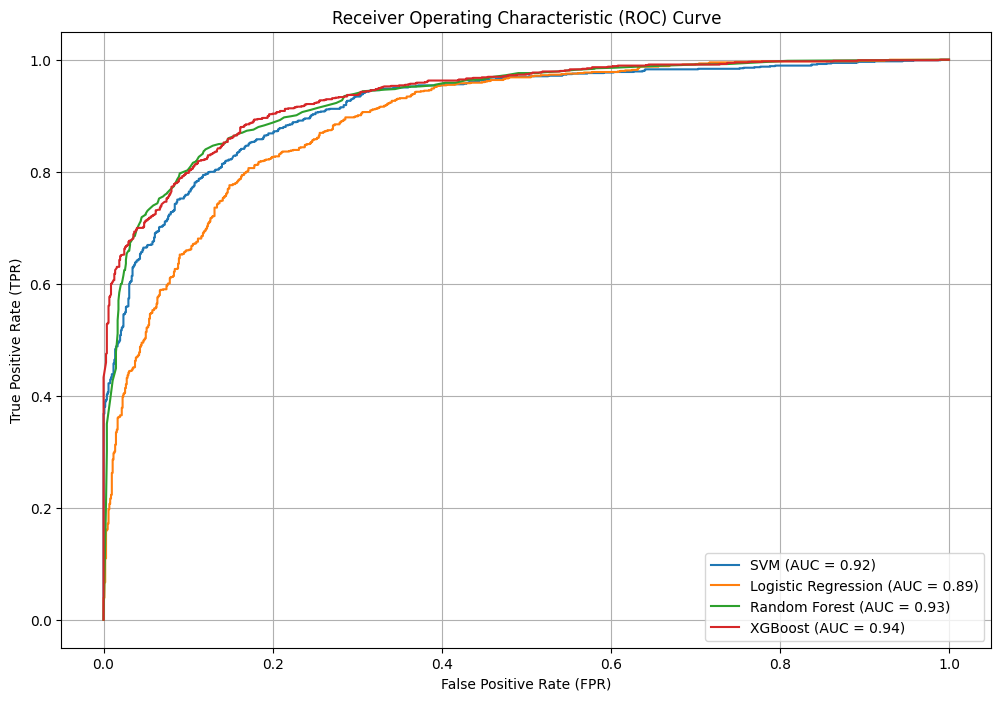

In [38]:
# Inisialisasi plot
plt.figure(figsize=(12, 8))

# Evaluation menggunakan AUC-ROC
for name, model in models.items():
    # Menghitung ROC curve dan AUC
    y_prob = model.predict_proba(x_test)[:, 1]  # Estimasi probabilitas untuk kelas positif
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot diagonal line (random classifier)
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Classifier (AUC = 0.5)")

# Menambahkan labels and title
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [39]:
# Print ROC-AUC score untuk setiap model
print('Evaluation ROC-AUC')
for name, model in models.items():
    y_prob = model.predict_proba(x_test)[:, 1]  # Probability estimates for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f'{name}: {roc_auc:.2f}')

Evaluation ROC-AUC
SVM: 0.92
Logistic Regression: 0.89
Random Forest: 0.93
XGBoost: 0.94


Berdasarkan hasil evaluasi dengan ROC-AUC tersebut, berikut beberapa hasil analisis yang dapat diambil.

- Support Vector Machine (SVM) (AUC = 0.92)
	- Memiliki performa AUC yang cukup baik, meskipun lebih rendah dibandingkan Random Forest dan XGBoost.
	- Masih menunjukkan kemampuan prediksi yang kuat, namun bisa jadi kurang optimal untuk data yang tidak terpisahkan secara linear.

- Logistic Regression (AUC = 0.89)
	- Model dengan performa terendah berdasarkan AUC.
	- Masih merupakan model baseline yang solid, tetapi lebih lemah dalam memisahkan kelas dibandingkan model lainnya.

- Random Forest (AUC = 0.93)
	- Performa yang sangat mendekati XGBoost.
	- ROC curve juga menunjukkan kemampuan pemisahan yang sangat baik antara kelas, namun sedikit kurang optimal dibandingkan XGBoost.

- XGBoost (AUC = 0.94)
	- Model dengan performa terbaik berdasarkan area under the curve (AUC).
	- Menunjukkan keseimbangan yang sangat baik antara True Positive Rate (TPR) dan False Positive Rate (FPR).
	- Indikasi bahwa model ini mampu memisahkan kelas dengan baik, baik untuk kelas positif (churn) maupun negatif (tidak churn).

In [ ]:
best_model = 'XGBoost'
models[best_model]

GradientBoostingClassifier(random_state=42)

Q: Jadi model mana yang terbaik?

A: Berdasarkan hasil evaluasi baik dari classification report, maupun dari ROC-AUC, model yang menggunakan algoritma XGBoost adalah model terbaik. Hal ini dibuktikan dengan bukti-bukti berikut.
- Model XGBoost memiliki score AUC yang tertinggi di antara semua model yakni sebesar 0.94.
- Model ini menghasilkan precision dan recall sangat seimbang.
- Akurasi keseluruhan dari model ini cukup tinggi yakni sebesar 85%.
- F1-score yang dihasilkan dari model ini juga konsisten menunjukkan keunggulan.
<!-- - Model ini mendukung evaluasi feature importance yang baik, memudahkan interpretasi hasil untuk bisnis. -->

## Feature Importance

> Feature Contract_Month-to-month merupakan feature yang paling berpengaruh dalam model. Diikuti dengan feature PaymentMethod_Electronic check.

<Figure size 1000x600 with 0 Axes>

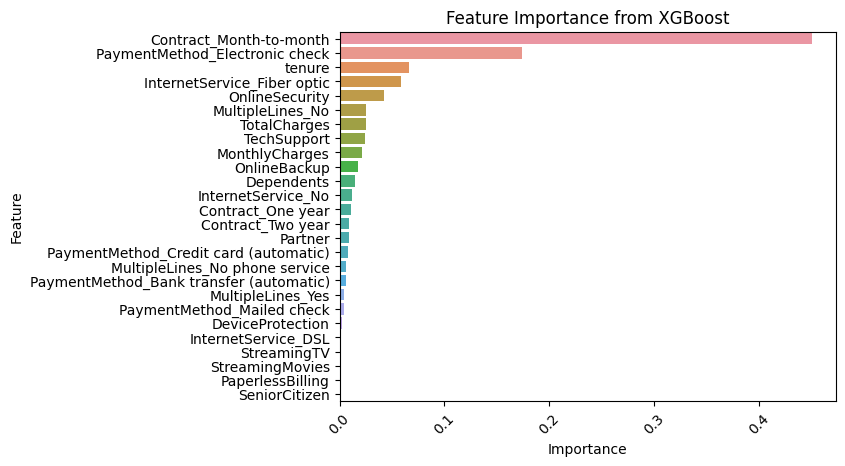

In [41]:
# Membuat model menjadi dapat diinterpretasikan
feature_importances = models[best_model].feature_importances_

# Membuat dataframe untuk menampilkan feature importance
feature_names = x.columns 
df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Mengurutkan feature berdasarkan importance
df_importance = df_importance.sort_values(by='Importance', ascending=False)

# Plot visualisasi
plt.figure(figsize=(10, 6))
df_importance.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title(f'Feature Importance from {best_model}')
sns.barplot(x='Importance', y='Feature', data=df_importance)
# plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

Berdasarkan grafik tersebut, dapat diambil insight-insight sebagai berikut.
- Contract_Month-to-month merupakan fitur paling penting dalam model, dengan skor signifikan yang jauh lebih tinggi dibandingkan fitur lain. Hal ini menunjukkan bahwa pelanggan yang menggunakan kontrak bulanan memiliki peran besar dalam menentukan churn, mungkin karena fleksibilitas untuk berhenti kapan saja.

- PaymentMethod_Electronic check menjadi fitur kedua yang paling penting. Ini dapat menunjukkan bahwa metode pembayaran ini berkaitan erat dengan pola pelanggan yang cenderung churn.

- Tenure (lama waktu pelanggan telah berlangganan) adalah fitur yang cukup signifikan. Dimana semakin lama masa berlangganan, semakin kecil kemungkinan untuk churn. Ini adalah indikator kuat dalam memprediksi loyalitas pelanggan.

- InternetService_Fiber optic, pelanggan dengan layanan internet fiber optic memiliki pengaruh penting, yang mungkin berkaitan dengan harapan tinggi terhadap kecepatan internet.

- OnlineSecurity & TechSupport, dimana ketersediaan layanan tambahan ini menjadi faktor penting. Pelanggan yang tidak memiliki layanan ini mungkin merasa kurang puas dan lebih mungkin untuk berhenti.

- TotalCharges & MonthlyCharges, biaya total dan bulanan juga memiliki pengaruh, meskipun tidak sebesar fitur utama. Kemungkinan churn lebih besar pada pelanggan dengan tagihan tinggi.

- Dependents, adanya tanggungan juga memengaruhi churn, meskipun dalam tingkat sedang.

- Beberapa fitur seperti SeniorCitizen, PaperlessBilling, dan StreamingTV memiliki pengaruh yang kecil terhadap prediksi churn, menunjukkan bahwa mereka kurang relevan untuk memprediksi pelanggan yang berhenti.

# Level 4: Presenting the Findings

## Business Recommendations

Berdasarkan hasil dari seluruh proses, berikut adalah Business Recommendations untuk mengurangi churn pelanggan dan meningkatkan retensi.

- Tingkatkan Retensi Melalui Kontrak Jangka Panjang, perusahaan perlu mendorong pelanggan untuk beralih dari kontrak bulanan ke kontrak tahunan atau dua tahunan melalui insentif seperti diskon, bonus layanan, atau cashback.

- Fokus pada Pelanggan Baru dengan Masa Berlangganan Singkat, perusahaan perlu mengimplementasikan program loyalitas yang dirancang khusus untuk pelanggan baru, seperti bonus bulan gratis setelah 6 bulan atau diskon pada tahun pertama berlangganan.

- Promosikan Metode Pembayaran yang Stabil dan Minimalkan Risiko Elektronik Check, perusahaan perlu mempromosikan metode pembayaran otomatis seperti Credit Card (automatic) atau Bank Transfer (automatic) dengan insentif seperti diskon tagihan atau hadiah kecil. Selain itu, perusahaan juga perlu memperluas edukasi dan promosi untuk mengurangi penggunaan metode Electronic Check, yang sangat terkait dengan churn.

- Perbaiki dan Promosikan Layanan Tambahan (OnlineSecurity & TechSupport), perusahaan perlu menjadikan layanan seperti OnlineSecurity dan TechSupport sebagai bagian dari paket inti atau tawarkan upgrade dengan harga terjangkau. Perusahaan juga perlu memasarkan layanan tambahan ini sebagai fitur penting untuk meningkatkan pengalaman pelanggan.

- Atur Harga dan Penawaran Layanan dengan Bijak, perusahaan harus melakukan segmentasi pelanggan berdasarkan tingkat biaya bulanan (MonthlyCharges) dan total tagihan (TotalCharges) untuk menawarkan paket yang sesuai dengan kemampuan mereka.
Perusahaan juga perlu mempertimbangkan untuk memberikan paket diskon atau layanan bundling bagi pelanggan dengan tagihan tinggi untuk meningkatkan kepuasan.